In [11]:
get_ipython().run_line_magic('matplotlib', 'inline')
import pandas as pd
import numpy as np
import seaborn as sns

from datetime import datetime

from sklearn.externals import joblib 
import glob
#!/usr/bin/env python
# coding: utf-8
get_ipython().run_line_magic('matplotlib', 'inline')
import pandas as pd
import time
import numpy as np
from datetime import datetime
from sklearn.externals import joblib 
import os
from konlpy.tag import Mecab
import lightgbm as lgb
print(lgb.__version__)

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib 
from sklearn.model_selection import StratifiedKFold

import gc

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings(action='ignore')


import torch
print(torch.__version__)
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary

from tools import eval_summary

print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
device

2.3.2
1.3.1
GeForce RTX 2070 SUPER
True


device(type='cuda', index=0)

In [26]:
dfs = []
for path in glob.glob('submit/e1/**/*lgb.csv', recursive=True):
    c = path.split('/')[-1].replace('.csv', '').replace('smishing_', '')
    df = pd.read_csv(path, index_col=0).rename(columns={'smishing':c})
    dfs.append(df)      
    
df_test = pd.concat(dfs, axis=1)

df_test.head(10)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1626 entries, 340000 to 341625
Columns: 227 entries, 20200101T125632_30_5__3030_lgb to 20200101T125632_29_1__4909_lgb
dtypes: float64(227)
memory usage: 2.8 MB


In [52]:
dfs = []
for path in glob.glob('submit/e1/**/*lgb_score.csv', recursive=True):
    c = path.split('/')[-1].replace('.csv', '').replace('smishing_', '').replace('_score', '')
    df = pd.read_csv(path, index_col=0).rename(columns={'score':c})
    dfs.append(df)      
    
df_model = pd.concat(dfs, axis=1)

df_model.head(10)
df_model.info()

df_model = pd.merge(df_model, pd.read_csv('input/train.csv', index_col=0)['smishing'], 
                    left_index=True, right_index=True,
                    how='left')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295945 entries, 0 to 336378
Columns: 227 entries, 20200101T125632_21_5__1943_lgb to 20200101T125632_22_4__4455_lgb
dtypes: float64(227)
memory usage: 514.8 MB


In [53]:
df_model['smishing'].value_counts()

0    277242
1     18703
Name: smishing, dtype: int64

### param

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

model_ts = datetime.now().strftime('%Y%m%dT%H%M%S')

initscore_filename = ''
params = {
    'boosting':'gbdt',
#     'boosting':'dart',
    'num_leaves': 7, 
#     'max_depth': 5,
    'objective': 'binary',
    'metric':'auc',
    'num_threads': 2,
    'learning_rate': 0.005,
#     'is_unbalance': True,
    'scale_pos_weight':100,
    'bagging_fraction':1,
#     'bagging_freq':10,
    'feature_fraction':1,
    'initscore_filename':initscore_filename,
#     'lambda_l1':200,
#     'lambda_l2':2000,
#     'device_type':'gpu',
}

data_params = {
#     'max_bin':128,
    'enable_bundle': True,
}
num_round = 5000

### Train

In [58]:
fea_cols = [c for c in df_model.columns if c not in ['smishing', 'id', 'score']]
cat_cols = []

In [61]:
[df_model.drop(c, axis=1, inplace=True) for c in df_model.columns if 'smishing_' in c]
[df_test.drop(c, axis=1, inplace=True) for c in df_test.columns if 'smishing_' in c]

X = df_model[fea_cols].values
y = df_model['smishing'].values

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, random_state=8405)
cnt = 0
train_data = lgb.Dataset(X, label=y, feature_name=fea_cols, categorical_feature=cat_cols, 
                     free_raw_data=False, params=data_params)

# for train_index, valid_index in skf.split(X, y):
for train_index, valid_index in tqdm_notebook(skf.split(X, y), total=n_splits, desc = 'CV'):
    cnt = cnt + 1
    print('\n', '*' * 20, cnt, '*' * 20)

    train_set = train_data.subset(train_index, params=data_params).construct()
    valid_set = train_data.subset(valid_index, params=data_params).construct()
    print('train_set', np.unique(train_set.get_label(), return_counts=True))
    print('valid_set', np.unique(valid_set.get_label(), return_counts=True))

    bst = lgb.train(params, train_set, num_round, categorical_feature=cat_cols,
                    early_stopping_rounds=300, 
                    valid_sets=[train_set, valid_set],
                    verbose_eval=200,
                    # init_model=init_model,
                   )

    print('Best Iteration:', bst.best_iteration)
    pred_tag = 'e_{}__{}'.format(cnt, bst.best_iteration)

    renamed_cols = fea_cols

    impt_dict = {k:v for k, v in zip(renamed_cols, bst.feature_importance(importance_type='split'))}
    print('split:', sorted(impt_dict.items(), key=(lambda x:x[1]), reverse=True)[:5])
    joblib.dump(impt_dict, 'model/{}_{}_split.pkl'.format(model_ts, pred_tag))

    impt_dict = {k:v for k, v in zip(renamed_cols, bst.feature_importance(importance_type='gain'))}    
    print('gain:', sorted(impt_dict.items(), key=(lambda x:x[1]), reverse=True)[:5])
    joblib.dump(impt_dict, 'model/{}_gain.pkl'.format(model_ts, pred_tag))

    print('model\n', eval_summary(y, bst.predict(X), cut_off=0.5))

    df_test['smishing_{}'.format(cnt)] = bst.predict(df_test[fea_cols].values)    
    df_test[['smishing_{}'.format(cnt)]].to_csv('submit/{}_{}_lgb.csv'.format(model_ts, pred_tag), index=True)

    df_model['score'] = bst.predict(df_model[fea_cols].values)    
    df_model[['score']].to_csv('submit/{}_{}_lgb_score.csv'.format(model_ts, pred_tag), index=True)


 ******************** 1 ********************
train_set (array([0., 1.], dtype=float32), array([221793,  14962]))
valid_set (array([0., 1.], dtype=float32), array([55449,  3741]))
Training until validation scores don't improve for 300 rounds
[200]	training's auc: 1	valid_1's auc: 0.996926
[400]	training's auc: 1	valid_1's auc: 0.996926
[600]	training's auc: 1	valid_1's auc: 0.997861
[800]	training's auc: 1	valid_1's auc: 0.997861
Early stopping, best iteration is:
[691]	training's auc: 1	valid_1's auc: 0.997861
Best Iteration: 691
split: [('20200101T125632_2_3__2011_lgb', 618), ('20200101T125632_2_5__3029_lgb', 608), ('20200101T125632_21_4__4476_lgb', 474), ('20200101T125632_31_1__4640_lgb', 423), ('20200101T125632_34_1__3960_lgb', 413)]
gain: [('20200101T125632_2_1__4916_lgb', 39703515.61691058), ('20200101T125632_31_1__4640_lgb', 17555822.6693549), ('20200101T125632_21_4__4476_lgb', 782477.332223177), ('20200101T125632_41_1__4070_lgb', 322.24617643945385), ('20200101T125632_40_3__191

In [62]:
pred_cols = [c for c in df_test.columns if 'smishing_' in c]
print(len(pred_cols))
df_test['pred_max'] = df_test[pred_cols].max(axis=1)
df_test['pred_min'] = df_test[pred_cols].min(axis=1)
df_test['pred_mean'] = df_test[pred_cols].mean(axis=1)
df_test['pred_std'] = df_test[pred_cols].std(axis=1)

print(df_test['pred_std'].max(), df_test['pred_std'].min(), df_test['pred_std'].mean())

df_test['smishing'] = df_test['pred_mean']

5
0.4547714644090388 0.007495666136448372 0.05388141288151504


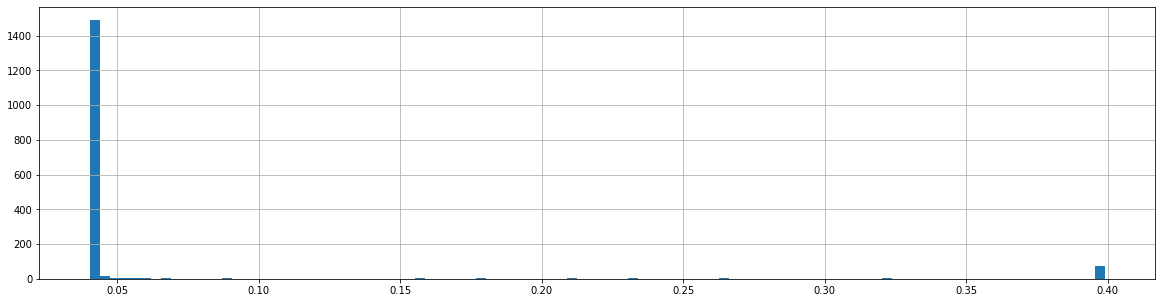

In [63]:
df_test['smishing'].hist(bins=100, figsize=(20, 5))

In [64]:
(df_test['smishing'] * 10).astype(int).value_counts(sort=False)

0    1524
1      13
2       7
3      82
Name: smishing, dtype: int64

In [65]:
model_ts

'20200101T181009'

In [66]:
df_test['smishing'] = df_test['smishing']
df_test[['smishing']].to_csv('submit/{}.csv'.format(model_ts), index=True)


In [ ]:
# df['smishing'] = df.mean(axis=1)
# df[['smishing']].to_csv('e1.csv')
# (df['smishing'] * 10).astype(int).value_counts(sort=False)

In [ ]:
df.sort_values('std', ascending=False)

In [ ]:
(df.loc[340746] * 100)

In [ ]:
def load_csv(csv_path, c):
    df = pd.read_csv(csv_path)
    display((df['smishing'] * 10).astype(int).value_counts(sort=False))
    df.plot(kind='scatter', x='id', y='smishing', figsize=(20, 5), s=5, c=c)
    df['tag'] = csv_path[-8:-4]
    df['color'] = c
    return df

In [ ]:
dfs = []
for i in [0, 2, 3, 4]:
    df = load_csv('20191231T141708_smishing_{}.csv'.format(i), 'blue')
    dfs.append(df)

In [ ]:
# df_t2 = load_csv('20191230T010609.csv', 'red')
df_t1_nn = load_csv('submit/20191229T074522.csv', 'green')
df_t1 = load_csv('submit/20191231T120011.csv', 'red')

df_curr = load_csv('submit/20191231T154959.csv', 'blue')

df_bad = load_csv('submit/20191231T151938_smishing_0.csv', 'gray')

# df_best_dart = load_csv('20191230T213920.csv', 'green')

In [ ]:
# df = df_best[['id']]
# df['smishing'] = (df_best['smishing'] + df_best_nn['smishing']) / 2

# df.to_csv('e2.csv', index=False)

In [ ]:
np.linalg.norm(df_t1_nn['smishing'].values - df_curr['smishing'].values)

In [ ]:
dfs = [
    df_t1,
#     df_best_nn
    df_curr,
#     df_best_dart
#     load_csv('20191230T010609_2.csv', 'gray'),
#     load_csv('20191230T124144.csv', 'green'),
#     load_csv('20191230T191206_go.csv', 'blue')
#     load_csv('submit/20191228T112709.csv', 'green'),
]
df = pd.concat(dfs).reset_index()


In [ ]:
df.plot(kind='scatter', x='id', y='smishing', figsize=(20, 10), s=4, c=df['color'])

In [ ]:
pos = 341000
cond = (pos < df['id']) & (df['id'] < pos + 100)
print(df[cond].shape)
df[cond].plot(kind='scatter', x='id', y='smishing', figsize=(20, 10), s=4, c=df[cond]['color'])


In [ ]:
df

In [ ]:
np.linalg.norm(df1['smishing'].values - df1_2['smishing'].values)

In [ ]:
np.linalg.norm(df2['smishing'].values - df1_2['smishing'].values)

In [ ]:
np.linalg.norm(df1['smishing'].values - df3['smishing'].values)

In [ ]:
np.linalg.norm(df2['smishing'].values - df3['smishing'].values)

In [ ]:
np.linalg.norm(df1['smishing'].values - df2['smishing'].values)

In [ ]:
f1 = joblib.load('data/df_merged_20191231T165424_6099_fea_dict.pkl')
f2 = joblib.load('data/df_merged_20191231T162533_2022_fea_dict.pkl')

In [ ]:
set(f1.values()) & set(f2.values())

In [ ]:
f2